# Unsupervised image denoising

## Import libraries

In [1]:
import torch
import torchvision
from torch.utils.data import Dataset
from os import listdir
from os.path import join
from torchvision.transforms import Compose, ToTensor, ToPILImage, Resize, Lambda, Normalize, Grayscale
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from skimage.feature import hog
from math import log10
from sklearn import svm
from tqdm.notebook import tqdm
import os
import matplotlib.image as img
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Load data

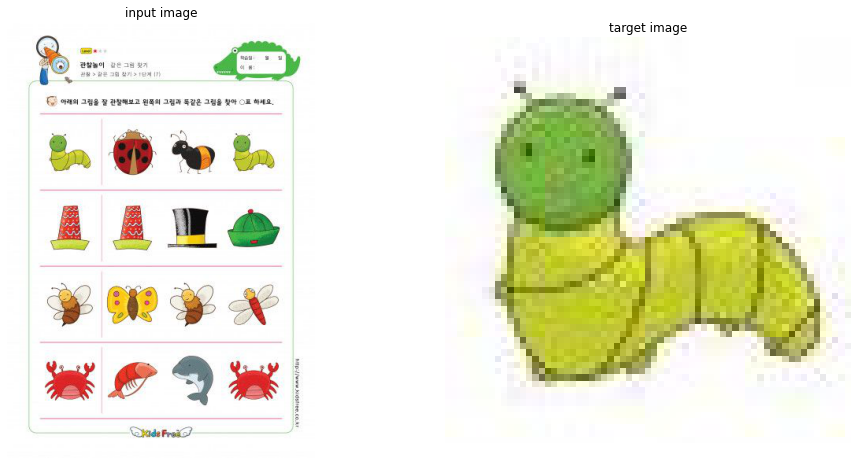

In [2]:
directory_data  = './'
image_train_data   = 'image_train2.jpg'
image_target_data   = 'image_target2.jpg'
image_train      = img.imread(os.path.join(directory_data, image_train_data))
image_target    = img.imread(os.path.join(directory_data,image_target_data))


plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(image_train, cmap = 'gray')
plt.title('input image')
plt.axis('off')
plt.subplot(122)
plt.imshow(image_target, cmap = 'gray')
plt.title('target image')
plt.axis('off')

num_train   = image_train.shape
num_target  = image_target.shape

## Compute Derivative First Order, 미분을 이용해서 윤곽 정보만 땀

In [3]:
def compute_derivative_first_order(data, axis): 

    D = np.pad(data,(1,1), mode = 'edge')   # use numpy.pad function 
    if axis == 'x':
      derivative = np.roll(D,1)-D   # use numpy.roll function
        
    elif axis == 'y':
      derivative = np.roll(D,1,axis=0) -D# use numpy.roll function
        
    dD = derivative[1:data.shape[0]+1,1:data.shape[1]+1]   # remove the first and the last rows and columns for the boundary condition

    return(dD)

## 연산량을 줄이기 위해 Color Image를 Gray로 바꾸고
### 미분을 해서 윤곽 정보만 남김

In [4]:
def gray_scale(image):
  if len(image.shape) == 3:
    image = image.mean(2)
  dx = compute_derivative_first_order(image,'x')
  dy = compute_derivative_first_order(image,'y')
  gradient_mag = np.sqrt(np.power(dx,2) + np.power(dy,2) )
  return gradient_mag

In [5]:
print('*************************************************')
print('size of train :', image_train.shape)
print('*************************************************')
print('size of target :', image_target.shape)

*************************************************
size of train : (553, 391, 3)
*************************************************
size of target : (65, 65, 3)


*************************************************
size of train : torch.Size([553, 391])
*************************************************
size of target : torch.Size([65, 65])


(-0.5, 64.5, 64.5, -0.5)

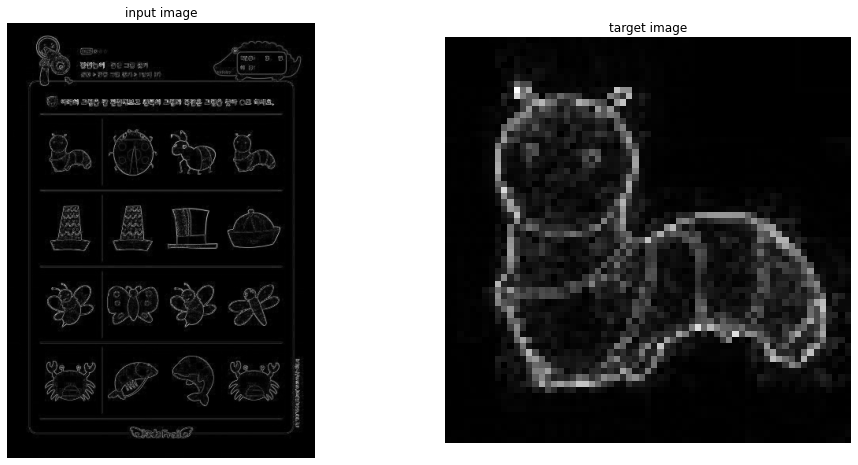

In [6]:

image_train_gray = torch.from_numpy(gray_scale(image_train))
image_target_gray = torch.from_numpy(gray_scale(image_target))
print('*************************************************')
print('size of train :', image_train_gray.shape )
print('*************************************************')
print('size of target :', image_target_gray.shape)

plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(image_train_gray, cmap = 'gray')
plt.title('input image')
plt.axis('off')
plt.subplot(122)
plt.imshow(image_target_gray, cmap = 'gray')
plt.title('target image')
plt.axis('off')

In [7]:
def cross_correlation(image, window, stride=1, pad=0):
  h, w = image.shape

  window_h, window_w = window.shape

  window_std = window.std()
  window_mean = window.mean()
  out_h = int((h+2*pad-window_h)/stride +1)
  out_w = int((w+2*pad-window_w)/stride +1)
  input = torch.nn.functional.pad(input=image, pad=(pad,pad,pad,pad), mode='constant', value = 0)
  # add padding to height and width. 
  #  # padding으로 모양이 커진 in_X
  # print(n, n_f, out_h, out_w)
  out = torch.zeros((out_h, out_w))
  for h in range(out_h):
    h_start = h*stride # 시작지점에 stride 적용
    h_end = h_start + window_h 
    for w in range(out_w):
      w_start  = w*stride # 시작지점에 stride 적용
      w_end = w_start + window_w
      target = input[h_start:h_end, w_start:w_end]
      target_std = target.std()
      target_mean = target.mean()
      out[h, w] = ((target - target_mean) *(window-window_mean)).mean()/(target_std*window_std)
  return out

## Cross Correlation을 이용한 output

torch.Size([65, 65])
32


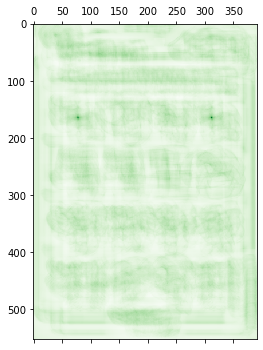

In [13]:
print(image_target_gray.shape)
num_train_row = image_train.shape[0]
num_train_col = image_train.shape[1]
num_target_row = image_target_gray.shape[0]
num_target_col = image_target_gray.shape[1]

padding = num_target_col // 2
print(padding)
out = cross_correlation(image = image_train_gray,window = image_target_gray,stride = 1, pad = padding)
#결과 값 중 가장 높은 것의 인덱스를 가져옴
plt.matshow(out,cmap = 'Greens') # colormap을 이용해서 cross correlation 값이 높은 곳을 나타냄,
# 색이 진할 수록 높은것

In [14]:

ret = out.argmax() #결과 값 중 가장 높은 것의 인덱스를 가져옴

x =  ret % num_train_col # x,y 인덱스를 계산
y = ret // num_train_col
print(x)
print(y)

tensor(78)
tensor(165)


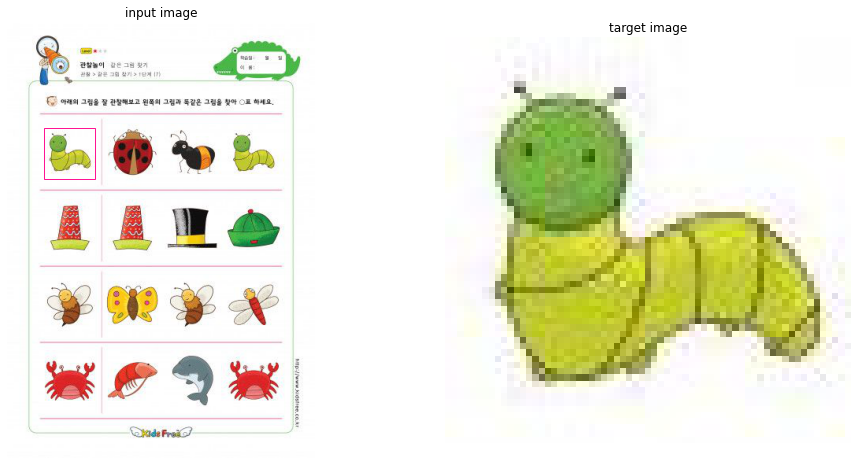

In [15]:
import matplotlib.patches as patches

plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(image_train, cmap = 'gray')
plt.gca().add_patch(patches.Rectangle((x -padding ,y-padding),width = num_target_row,height = num_target_col,edgecolor = 'deeppink',facecolor='lightgray',fill = False,))
plt.title('input image')
plt.axis('off')
plt.subplot(122)
plt.imshow(image_target, cmap = 'gray')
plt.title('target image')
plt.axis('off')

plt.show()